In [1]:
# !rm -r vision/
# !wget https://github.com/pytorch/vision/archive/f40c8df02c197d1a9e194210e40dee0e6a6cb1c3.zip
# !unzip -q f40c8df02c197d1a9e194210e40dee0e6a6cb1c3.zip
# !rm f40c8df02c197d1a9e194210e40dee0e6a6cb1c3.zip
# !mv vision-f40c8df02c197d1a9e194210e40dee0e6a6cb1c3/ vision/
# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

## Libraries
I have already put all the 'import' of libraries in the following two cells.

The libraries in the first cell is downloaded from having executing the above cell, so basically you don't need to run it again as I have already put all these .py files into the .zip file.

In [30]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [31]:
import matplotlib
import cv2, copy, os, glob
import numpy as np
import matplotlib.pyplot as plt
import ca_utils
from ca_utils import ResNet, BasicBlock
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import v2
from torchvision.ops import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET

## Question 1
The following two functions are my answers to the Question 1

In [4]:
def compute_gradient_magnitude(gr_im, kx, ky):

    # convert 2-dimensional numpy array of data type uint8 to that of float64 
    gr_im_float = gr_im.astype(np.float64)
    kx, ky = kx.astype(np.float64), ky.astype(np.float64)

    # convolution 
    I_x = cv2.filter2D(gr_im_float, -1, kx)
    I_y = cv2.filter2D(gr_im_float, -1, ky)

    # calculate the gradient magnitude 
    magnitude = np.sqrt(I_x**2 + I_y**2)

    return magnitude

In [5]:
def compute_gradient_direction(gr_im, kx, ky):

    # convert 2-dimensional numpy array of data type uint8 to that of float64
    gr_im_float = gr_im.astype(np.float64)
    kx, ky = kx.astype(np.float64), ky.astype(np.float64)

    # convolution   
    I_x = cv2.filter2D(gr_im_float, -1, kx)
    I_y = cv2.filter2D(gr_im_float, -1, ky)

    # calculate the direction
    direction = np.arctan2(I_y, I_x)

    return direction

The next cell is used to test these two function and output the shape as well as the data type of the results

In [6]:
# read an image
img = cv2.imread('data/shapes.png')

# convert image to grayscale
gr_im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# For example:
# construct the Sobel x-axis kernel
kx = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.int8)
# construct the Sobel y-axis kernel
ky = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype=np.int8)

magnitude = compute_gradient_magnitude(gr_im, kx, ky)
direction = compute_gradient_direction(gr_im, kx, ky)

print(f"""
      The shape of magnitude:      {magnitude.shape}\n
      The shape of direction:      {direction.shape}\n
      The shape of input gr_im:    {gr_im.shape}\n
      The data type of magnitude:  {magnitude.dtype}\n
      The data type of direction:  {direction.dtype}""")


      The shape of magnitude:      (720, 720)

      The shape of direction:      (720, 720)

      The shape of input gr_im:    (720, 720)

      The data type of magnitude:  float64

      The data type of direction:  float64


## Question 2
The following function is my answers to the Question 2

In [7]:
def generate_bovw_spatial_histogram(im, locations, clusters, division):
    
    # calculate the product of its dimensions
    num_part = np.prod(division)

    # initialize the spatial histogram
    num_bins = num_part * len(np.unique(clusters))
    spatial_histogram = np.zeros(num_bins, dtype=np.int64)
    
    # calculate the size of each division
    div_height = im.shape[0] // division[0]
    div_width = im.shape[1] // division[1]
    
    # calculate the histogram for N points
    for i, loc in enumerate(locations):

        # x_axis belongs to which part
        div_x = int(loc[0] // div_width)

        # y_axis belongs to which part
        div_y = int(loc[1] // div_height)

        # assign each point to 0 - (division[0] * division[1] - 1) parts from left to right then top to bottom
        div_idx = div_y * division[1] + div_x
        cluster_id = clusters[i]

        # accumulate points of which cluster(cluster_id) to its relative part
        spatial_histogram[div_idx * len(np.unique(clusters)) + cluster_id] += 1

    # save spatial_histogram for each division
    np.save(f"histogram_division{num_part}.npy", spatial_histogram)

    # save interest image for each division
    interest_img = ca_utils.show_interest_points(im, locations[:, 0], locations[:, 1])

    # plot division lines and text
    for div_y in range(1, division[0]):
        cv2.line(interest_img, (0, div_height * div_y), (im.shape[1], div_height * div_y), (0, 200, 255), 10)
    for div_x in range(1, division[1]):
        cv2.line(interest_img, (div_width * div_x, 0), (div_width * div_x, im.shape[0]), (0, 200, 255), 10)

    # add Q[1] to Q[num_part] labels on the image
    for i in range(division[0]):
        for j in range(division[1]):
            label = f"Q{i * division[1] + j + 1}"
            org = (int(div_width * (j + 0.4)), int(div_height * (i + 0.5)))
            cv2.putText(interest_img, label, org, cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 200, 255), 10)

    # save image_division
    cv2.imwrite(f"image_division{num_part}.png", interest_img)

    # plot the histogram
    no_clusters = np.max(clusters) + 1
    
    if num_part > 1:
        fig, axes = plt.subplots(division[0], division[1], figsize=(15, 5))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(1, 1, figsize=(15, 5))
        axes = [axes]

    # plot histogram for each part
    for i in range(num_part):
        start_idx = i * no_clusters
        end_idx = start_idx + no_clusters
        axes[i].bar(range(no_clusters), spatial_histogram[start_idx:end_idx])
        axes[i].set_title(f'Vocabulary Generated Q{i+1}')
        axes[i].set_xlabel('Visual Word Index')
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()

    # save the histogram for each division
    plt.savefig(f"histogram_division{num_part}.png")
    
    return spatial_histogram

The next cell is the example for Question 2 and use random seed = 49 for reproducibility 

Division [1, 1] - Spatial Histogram: [ 9  8 11 14  9  6 14 14  5 10]

Division [2, 2] - Spatial Histogram: [4 2 3 5 4 5 6 4 0 3 4 4 6 2 4 1 4 1 5 2 0 2 2 5 0 0 1 4 0 2 1 0 0 2 1 0 3
 5 0 3]

Division [2, 3] - Spatial Histogram: [2 1 3 4 3 4 2 3 0 2 3 3 2 1 2 1 4 2 2 1 3 2 4 2 3 1 4 0 3 2 0 1 2 4 0 0 1
 2 0 1 0 1 0 3 1 0 1 3 0 2 1 0 0 0 0 0 2 4 0 2]



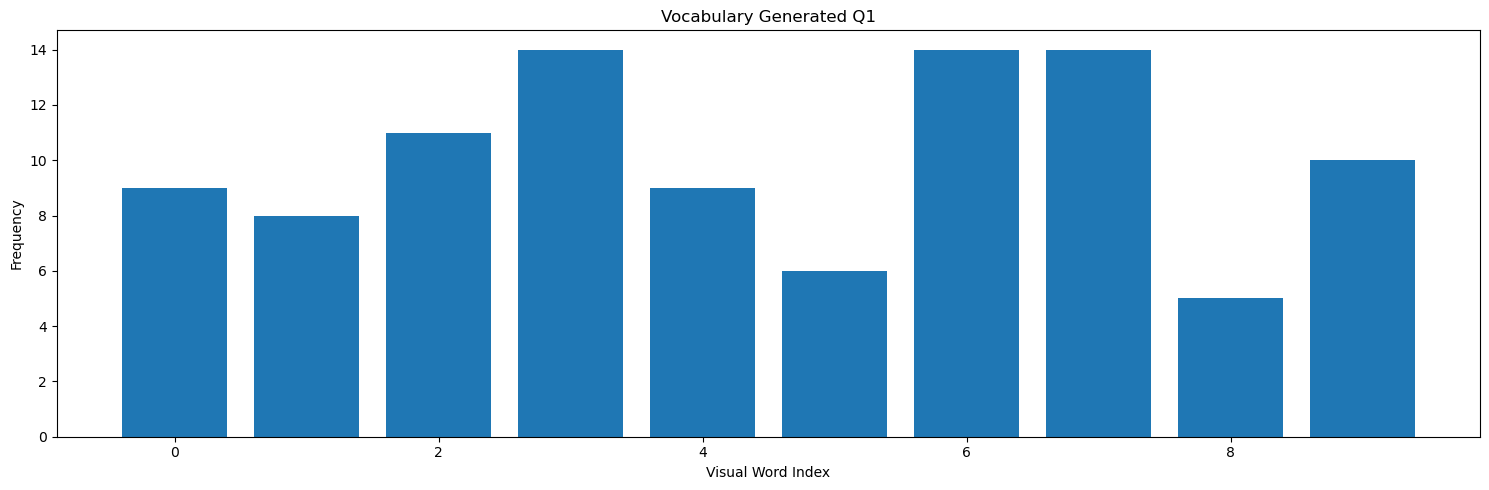

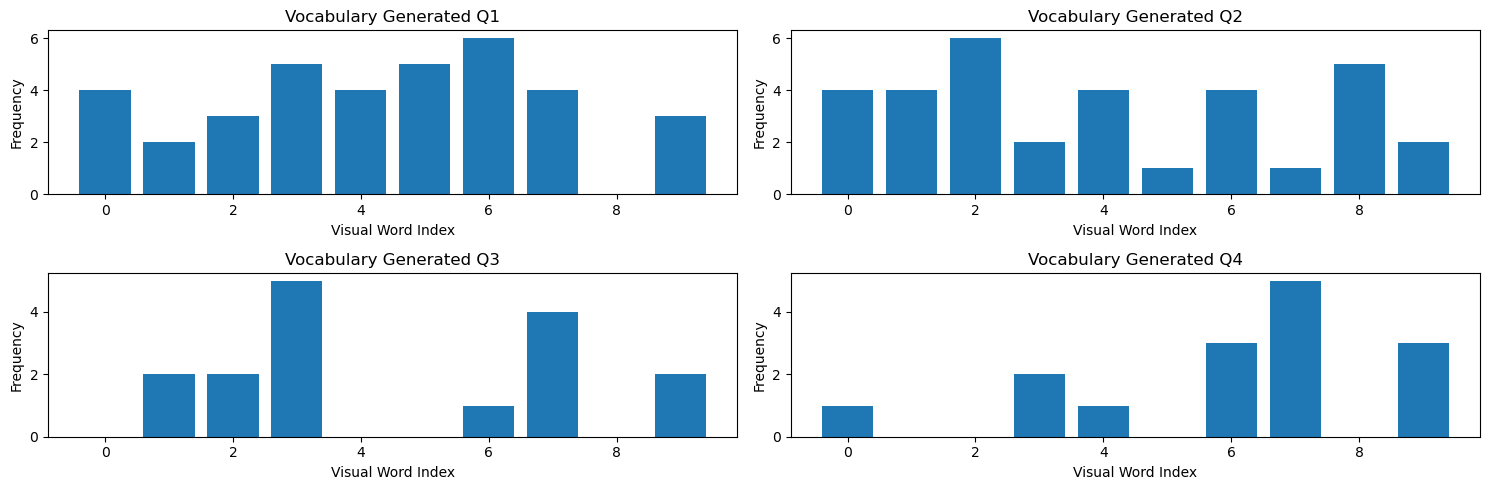

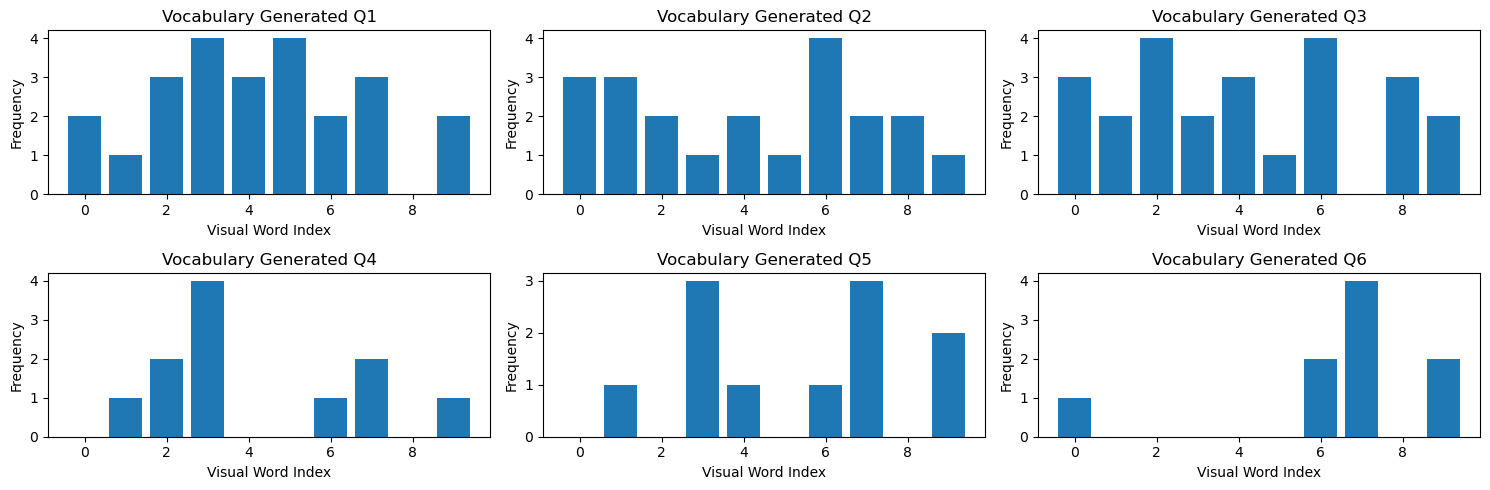

In [8]:
im = cv2.imread('data/notre_dame_1.jpg')

# fixed random seed = 49 for reproducibility 
np.random.seed(49)
N = 100
locations = np.random.randint(0, min(im.shape[:2]), (N, 2))
clusters = np.random.randint(0, 10, N)
divisions = [[1, 1], [2, 2], [2, 3]]

for i, division in enumerate(divisions):
    spatial_histogram = generate_bovw_spatial_histogram(im, locations, clusters, division)
    print(f"Division {division} - Spatial Histogram: {spatial_histogram}\n")

load the .npy result of Question 2

In [26]:
# load the .npy result of Question 2
for division in divisions:
    histogram = np.load(f"outputs_Q2/histogram_division{np.prod(division)}.npy")
    print(histogram)

[ 9  8 11 14  9  6 14 14  5 10]
[4 2 3 5 4 5 6 4 0 3 4 4 6 2 4 1 4 1 5 2 0 2 2 5 0 0 1 4 0 2 1 0 0 2 1 0 3
 5 0 3]
[2 1 3 4 3 4 2 3 0 2 3 3 2 1 2 1 4 2 2 1 3 2 4 2 3 1 4 0 3 2 0 1 2 4 0 0 1
 2 0 1 0 1 0 3 1 0 1 3 0 2 1 0 0 0 0 0 2 4 0 2]


## Question 3
The compute_rotation_matrix function as follow:

In [27]:
def compute_rotation_matrix(points, theta):
    # convert theta from degrees to radians
    theta_rad = np.radians(theta)
    
    # compute the centroid of the points
    centroid_x, centroid_y = np.mean(points, axis=0)
    
    # construct the two translation matrices
    translate_to_origin = np.array([
        [1, 0, -centroid_x],
        [0, 1, -centroid_y],
        [0, 0, 1]
    ], dtype=np.float64)

    translate_back = np.array([
        [1, 0, centroid_x],
        [0, 1, centroid_y],
        [0, 0, 1]
    ], dtype=np.float64)

    # construct the rotation matrix
    rotate = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0],
        [np.sin(theta_rad),  np.cos(theta_rad), 0],
        [0,                 0,                 1]
    ], dtype=np.float64)

    # combine the matrices
    rotation_matrix = np.dot(translate_back, np.dot(rotate, translate_to_origin))
    return rotation_matrix

the following cell is to test this function and output the shape as well as the data type of the results

In [28]:
# read the file "points.npy"
q3_points = np.load("data/points.npy")

# The example for the test: 
theta = 45
rotation_matrix = compute_rotation_matrix(q3_points, theta)
print(rotation_matrix)
print(f"""
The shape of the rotation_matrix: {rotation_matrix.shape}\n 
The data type of the rotation_matrix: {rotation_matrix.dtype}""")

[[   0.70710678   -0.70710678  643.61612368]
 [   0.70710678    0.70710678 -153.24637476]
 [   0.            0.            1.        ]]

The shape of the rotation_matrix: (3, 3)
 
The data type of the rotation_matrix: float64


## Question 4

In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

The training function

In [72]:
def train_cnn(model, train_loader):

    # parameters
    learning_rate = 0.003
    weight_decay = 0.5

    # number of epochs
    num_epoch = 80

    # load the last-trained weights
    if os.path.exists(f'data/weights_resnet.pth'):
        model.load_state_dict(torch.load(f'data/weights_resnet.pth'))

    # device: cuda or cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # map to device
    model = model.to(device)

    # make the parameters trainable
    for param in model.parameters():
        param.requires_grad = True

    # define optimizer and lr scheduler
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=num_epoch, eta_min=0.0001)
    
    correct = 0
    
    # store the best weights
    min_loss = 2.0
    best_weights = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epoch):
        # meter
        loss = AverageMeter()
        acc = AverageMeter()

        # switch to train mode
        model.train()

        tk0 = tqdm(train_loader, total=int(len(train_loader)))
        
        # for inputs, labels in train_loader:
        for batch_idx, (data, target) in enumerate(tk0):
            data, target = data.to(device), target.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            output = model(data)

            # get the index of the max log-probability
            pred = output.argmax(dim=1)

            # update correct and acc, loss
            correct_this = pred.eq(target.view_as(pred)).sum().item()
            loss_this = F.cross_entropy(output, target)
            
            # Backward + optimize
            loss_this.backward()
            optimizer.step()

            correct += correct_this
            acc_this = correct_this / target.shape[0] * 100.0
            acc.update(acc_this, target.shape[0])
            loss.update(loss_this.item(), target.shape[0])
        
        print('Epoch [{}] Train: Average loss: {:.4f}; Average accuracy: {:.4f}%; lr: {:.7f}\n'.format(epoch, loss.avg, acc.avg, scheduler.get_last_lr()[-1]))

        # deep copy the model
        if loss.avg < min_loss:
            min_loss = loss.avg
            # print(f"now minimum loss is {min_loss}")
            best_weights = copy.deepcopy(model.state_dict())

        scheduler.step()
    
    # save best model weights
    torch.save(best_weights, f'data/weights_resnet.pth')
    print(f'Best model weights saved to data/weights_resnet.pth')

Set the model, transform function, train_data and train_loader

In [73]:
# resNet model
model = ResNet(block=BasicBlock, layers=[1, 1, 1], num_classes=10)

def get_transform_q4(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    # v2.ToTensor() is deprecated, use following compose instead
    transforms.extend([v2.ToImage(), 
                       v2.ToDtype(torch.float32, scale=True), 
                       v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    if train:
        # during training, randomly rotate, scale the training images
        train_transforms = [
            # randomly rotate, scale
            v2.RandomAffine(degrees=15, scale=(0.9, 1.1)),
        ]
        transforms.extend(train_transforms)
    return v2.Compose(transforms)

# dataset
train_data = datasets.ImageFolder('EXCV10/train/', transform=get_transform_q4(train=True))

# Ddata loader
train_loader = DataLoader(train_data, batch_size=72, shuffle=True, num_workers=0, pin_memory=True)

Start to train the data

In [ ]:
# start to train the train_loader using the ResNet model
train_cnn(model, train_loader)

## Question 5
The test function

In [75]:
def test_cnn(model, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()

    # store predicted labels
    all_preds = []
    correct = 0

    # load your trained weights
    if os.path.exists(f'data/weights_resnet.pth'):
        model.load_state_dict(torch.load(f'data/weights_resnet.pth'))

    # device: cuda or cpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # switch to test mode
    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            loss_this = F.cross_entropy(output, target)

            # get the index of the max log-probability
            pred = output.argmax(dim=1)

            # update correct and acc, loss
            correct_this = pred.eq(target.view_as(pred)).sum().item()
            correct += correct_this
            acc_this = correct_this / target.shape[0] * 100.0
            acc.update(acc_this, target.shape[0])
            loss.update(loss_this.item(), target.shape[0])

            # collect the predicted labels
            all_preds.extend(pred.cpu().numpy())

    all_preds = np.array(all_preds, dtype=np.int64)

    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    
    return all_preds, acc.avg

Define the Dataset class, model, test_data and test_loader

In [76]:
# Dataset
class EXCV10TestImageFolder(datasets.ImageFolder):
    def __init__(self, *args, **kwargs):
        super(EXCV10TestImageFolder, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        # imgs is one of the attributes of ImageFolder, inheriting from DatasetFolder
        # imgs (list): List of (image path, class_index) tuples, same as samples of DatasetFolder
        img_path, label = self.imgs[index]
        pic = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(pic)
        return img, label
    
# resNet model
model = ResNet(block=BasicBlock, layers=[1, 1, 1], num_classes=10)

# Vanilla image transform
image_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Dataset
test_data = EXCV10TestImageFolder('EXCV10/val/', transform=image_transform)

# Data loader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

In [77]:
# predict the test_loader
predictions, accuracy = test_cnn(model, test_loader)
print(f"""
prediction labels: {predictions}\n
accuracy:          {accuracy}%
""")

Test: Average loss: 0.6994, Accuracy: 1531/2000 (76.55%)


prediction labels: [0 0 0 ... 9 9 9]

accuracy:          76.55%



## Question 6
compute the confusion matrix for the output labels generated in Question 5

In [63]:
def confusion_matrix(true, predictions):
    """
    Compute the confusion matrix based on true labels and predicted labels in Question 5

    Parameters:
    - true (array): True labels.
    - predictions (array): Predicted labels.

    Return:
    - cm (array): confusion matrix
    """

    # Identify unique classes
    classes = np.unique(np.concatenate((true, predictions)))
    n_classes = len(classes)

    cm = np.zeros((n_classes, n_classes))

    # Create a dictionary of class labels to indices
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}

    # Calculate the confusion matrix
    for tru, pred in zip(true, predictions):
        cm[class_to_index[tru], class_to_index[pred]] += 1

    return cm

In [64]:
true = []
# extract true labels
for _, target in test_loader:
    true.append(target.numpy())
true = np.concatenate(true).astype(np.int64)

cm = confusion_matrix(true, predictions)
print("confusion matrix:\n", cm)

confusion matrix:
 [[177.   6.   4.   1.   0.   0.   0.   0.   7.   5.]
 [ 10. 151.   0.  14.  11.   2.   1.  11.   0.   0.]
 [  1.   1. 187.   0.   0.   0.   1.   0.   0.  10.]
 [  1.  18.   0. 132.  17.  10.   1.  20.   1.   0.]
 [  2.  13.   0.  16. 153.   3.  11.   2.   0.   0.]
 [  0.  15.   1.  26.  25.  93.  21.  18.   1.   0.]
 [  1.   3.   2.   3.  18.  16. 149.   8.   0.   0.]
 [  1.  16.   0.  19.  12.   9.   3. 140.   0.   0.]
 [  7.   3.   0.   1.   0.   1.   0.   0. 174.  14.]
 [  7.   1.  13.   0.   0.   0.   2.   0.   2. 175.]]


## Question 7
The function count_masks(dataset) as following:

In [67]:
def count_masks(dataset):
    class_str2num = {'with_mask': 1, 'without_mask': 2, 'mask_weared_incorrect': 3}

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = len(class_str2num) + 1

    model = get_model(num_classes)
    model.load_state_dict(torch.load("data/weights_resnet7655.pth"))
    model.to(device)
    model.eval()
    
    # if it is instance of Subset, it needs .dataset
    original_dataset = dataset.dataset if isinstance(dataset, torch.utils.data.Subset) else dataset

    counts = np.zeros((len(dataset), 3), dtype=np.int64)
    mape_scores = []
    
    with torch.no_grad():
        for idx in range(len(dataset)):
            xml_file_path = os.path.join("MaskedFace/val/", original_dataset.antns[idx])
            _, _, true_labels = parse_xml(xml_file_path)

            # convert true_labels from class IDs to class counts
            true_counts = np.zeros(len(class_str2num), dtype=int)
            for label in true_labels:
                true_counts[label-1] += 1

            img, targets = original_dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)
            predictions = model(img_tensor)

            nms_indices = nms(predictions[0]['boxes'], predictions[0]['scores'], 0.08)
            pred_counts = np.zeros(len(class_str2num), dtype=int)
            
            for i in nms_indices:
                if predictions[0]['scores'][i].cpu().numpy() > 0.59:
                    # box = predictions[0]['boxes'][i].cpu().numpy()
                    # score = predictions[0]['scores'][i].cpu().numpy()
                    label = predictions[0]['labels'][i].cpu().item()
                    pred_counts[label - 1] += 1

            class_mape_scores = np.abs((true_counts - pred_counts) / np.maximum(true_counts, 1)) * 100
            mape_score = np.mean(class_mape_scores)
            mape_scores.append(mape_score)

            counts[idx] = pred_counts
    
    overall_mape = np.mean(mape_scores)
    
    return counts, overall_mape

Define the parse_xml function

In [68]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    labels = []
    for boxes in root.iter('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        box = [xmin, ymin, xmax, ymax]
        bboxes.append(box)
        labels.append(int(class_str2num[boxes.find("name").text]))
    return filename, bboxes, labels

In [69]:
# dataset
class MaskedFaceTestDataset(Dataset):
    def __init__(self, root, transforms=None):
        super(MaskedFaceTestDataset, self).__init__()
        # self.imgs = sorted(glob.glob(os.path.join(root, '*.png')))
        self.root = root
        self.transforms = transforms
        self.antns = sorted([f for f in os.listdir(root) if f.endswith('.xml')])

    def __getitem__(self, index):
        # load annotation
        filename, boxes, labels = parse_xml(os.path.join(self.root, self.antns[index]))
        # load image
        img_path = os.path.join(self.root, filename)
        img = Image.open(img_path).convert('RGB')
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = boxes.shape[0]
        # classes
        labels = torch.tensor(labels, dtype=torch.int64)
        image_id = int(torch.tensor([index]))
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # # For PIL Images, .size property is used
        # w, h = img.size
        # boxes[:, 0::2].clamp_(min=0, max=w)
        # boxes[:, 1::2].clamp_(min=0, max=h)
        # keep = (boxes[:, 3]>boxes[:, 1]) & (boxes[:, 2]>boxes[:, 0])
        # boxes = boxes[keep]
        # labels = labels[keep]
        # area = area[keep]
        # iscrowd = iscrowd[keep]

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.antns)

In [70]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [71]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    # v2.ToTensor() is deprecated, use following compose instead
    transforms.extend([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(v2.RandomHorizontalFlip(0.5))
    return v2.Compose(transforms)

Define n train set to trained and tested

In [212]:
# define the class
class_str2num = {'with_mask': 1, 'without_mask': 2, 'mask_weared_incorrect': 3}

# use our dataset and defined transformations
train_dataset = MaskedFaceTestDataset(root= 'MaskedFace/train', transforms = get_transform(train=True))
test_dataset = MaskedFaceTestDataset(root= 'MaskedFace/val', transforms = get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
train_indices = torch.randperm(len(train_dataset)).tolist()
test_indices = torch.randperm(len(test_dataset)).tolist()
# first n examples
# because of the constraint of computational resources, I just use 100 samples.
# Please feel free to use more samples if you have enough resources
n = 682
train_dataset = torch.utils.data.Subset(train_dataset, train_indices[:n])
test_dataset = torch.utils.data.Subset(test_dataset, test_indices[:n])
# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(train_indices+test_indices), len(train_dataset), len(test_dataset)))

We have: 767 examples, 682 are training and 85 testing


Define the hyperparameters

In [213]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs = 10
num_classes = len(class_str2num) + 1

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0005)

lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

c:\Users\Docky\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train the dataset and save the best weights

In [214]:
for epoch in range(num_epochs):
    print(epoch)
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=20)
    
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)
    # update the learning rate
    lr_scheduler.step()
torch.save(model.state_dict(), 'data/weights_mask0803.pth')

0
Epoch: [0]  [  0/341]  eta: 0:05:03  lr: 0.000000  loss: 2.2602 (2.2602)  loss_classifier: 1.0409 (1.0409)  loss_box_reg: 0.1314 (0.1314)  loss_objectness: 1.0276 (1.0276)  loss_rpn_box_reg: 0.0603 (0.0603)  time: 0.8891  data: 0.0402  max mem: 4447
Epoch: [0]  [ 20/341]  eta: 0:02:14  lr: 0.000006  loss: 0.9760 (1.2538)  loss_classifier: 0.7242 (0.7664)  loss_box_reg: 0.1132 (0.1533)  loss_objectness: 0.1521 (0.2970)  loss_rpn_box_reg: 0.0205 (0.0370)  time: 0.3947  data: 0.0199  max mem: 4447
Epoch: [0]  [ 40/341]  eta: 0:02:02  lr: 0.000012  loss: 0.5921 (0.9487)  loss_classifier: 0.2806 (0.5369)  loss_box_reg: 0.1352 (0.1709)  loss_objectness: 0.0922 (0.2127)  loss_rpn_box_reg: 0.0150 (0.0282)  time: 0.3956  data: 0.0197  max mem: 4479
Epoch: [0]  [ 60/341]  eta: 0:01:54  lr: 0.000018  loss: 0.4638 (0.8107)  loss_classifier: 0.1771 (0.4287)  loss_box_reg: 0.1802 (0.1805)  loss_objectness: 0.0591 (0.1776)  loss_rpn_box_reg: 0.0101 (0.0239)  time: 0.4033  data: 0.0200  max mem: 448

Run the count_masks using the best weights I trained and get the results

In [349]:
cn, mape=count_masks(test_dataset)
print(f"count_classes is {cn}, mape is {mape:.2f}%")

count_classes is [[19  0  1]
 [ 3  3  0]
 [ 2  0  0]
 [ 2  0  0]
 [ 7  0  0]
 [ 8  0  0]
 [ 2  0  0]
 [11  0  0]
 [ 1  0  0]
 [ 2  2  0]
 [ 6  1  0]
 [ 0  1  0]
 [ 3  0  0]
 [ 2  0  0]
 [ 1  3  0]
 [ 4  3  0]
 [17  1  0]
 [ 1  0  0]
 [ 2  3  0]
 [ 6  1  0]
 [ 7  0  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 1  1  0]
 [10  0  0]
 [ 1  0  0]
 [10  0  0]
 [ 2 10  0]
 [ 1  0  0]
 [10  0  0]
 [ 0  1  0]
 [10  0  0]
 [49  0  0]
 [ 2  0  0]
 [ 1  0  0]
 [13  1  0]
 [ 2  0  0]
 [ 0  0  0]
 [25 14  0]
 [ 4  7  0]
 [ 1  0  1]
 [ 1  0  0]
 [ 1  0  0]
 [ 9  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [11  2  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 2  0  1]
 [19  0  1]
 [ 7  1  0]
 [ 3  0  0]
 [ 4  0  0]
 [ 8  0  0]
 [ 8  0  0]
 [ 1  0  0]
 [ 0  1  0]
 [ 5  0  0]
 [ 4  0  0]
 [ 1  0  0]
 [ 0  0  1]
 [ 5  0  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 8  0  0]
 [ 1  0  0]
 [ 2  0  0]
 [ 2  0  0]
 [ 2  0  0]
 [ 2  1  0]
 [ 6  0  0]
 [ 0  1  0]
 [19  1  0]
 [ 1  6  0]
 [ 6  1  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 1  0  0]
 [ 1  0  0]
 [14  0  0]
 [ 3  0  0]

Test cell: to plot the single predicted result to see how to alter the parameters and what the problem is

filename: mask-148.png, true_labels: [1, 2, 2, 1, 2, 1]
true_counts: [3 3 0]
Counts: [2 3 0]
Scores: ['0.92', '0.92', '0.91', '0.89', '0.88']
Overall MAPE: 11.111111111111109%


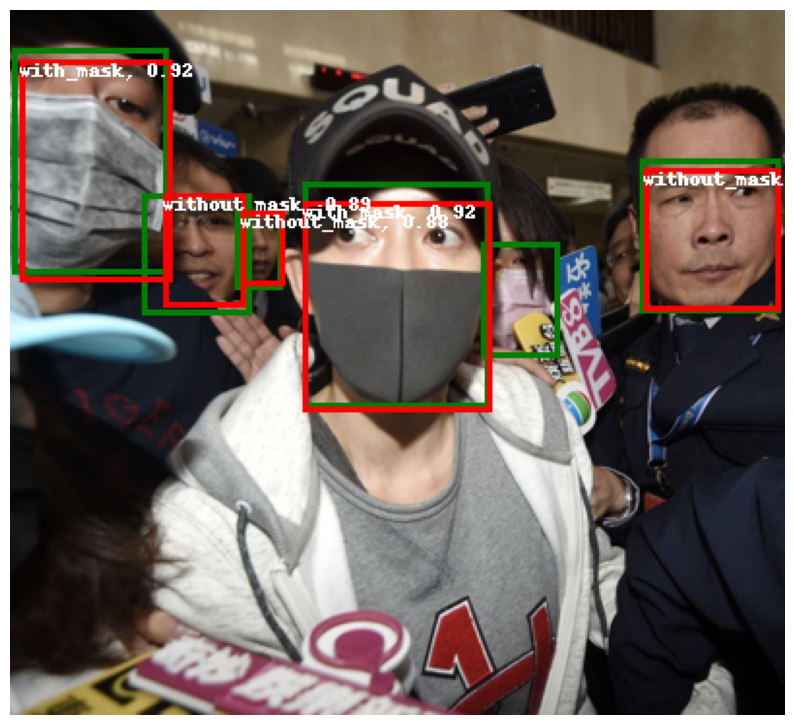

In [355]:
# this is to plot the single predicted result to see how to alter the parameters and what the problem is

class_str2num = {'with_mask': 1, 'without_mask': 2, 'mask_weared_incorrect': 3}
class_num2str = {v: k for k, v in class_str2num.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_str2num) + 1

model = get_model(num_classes)

# load the best model trained before
model.load_state_dict(torch.load("data/weights_mask.pth"))
model.to(device)
model.eval()

# if it is instance of Subset, it needs .dataset
original_dataset = test_dataset.dataset if isinstance(test_dataset, torch.utils.data.Subset) else test_dataset

mape_scores = []

with torch.no_grad():
    idx = 18
    xml_file_path = os.path.join("MaskedFace/val/", original_dataset.antns[idx])
    filename, true_boxes, true_labels = parse_xml(xml_file_path)
    print(f"filename: {filename}, true_labels: {true_labels}")
    # image = Image.open(os.path.join('MaskedFace/val/',filename))

    # convert true_labels from class IDs to class counts
    true_counts = np.zeros(len(class_str2num), dtype=int)
    for label in true_labels:
        true_counts[label-1] += 1
    print(f"true_counts: {true_counts}")

    img, targets = original_dataset[idx]

    img_pil = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    if img_pil.mode != 'RGB':
        img_pil = img_pil.convert('RGB')

    draw = ImageDraw.Draw(img_pil)

    for box in targets['boxes']:
        draw.rectangle([(box[0].item(), box[1].item()), (box[2].item(), box[3].item())], outline="green", width=3)

    img_tensor = img.unsqueeze(0).to(device)
    predictions = model(img_tensor)

    keep = nms(predictions[0]['boxes'], predictions[0]['scores'], 0.08)
    pred_counts = np.zeros(len(class_str2num), dtype=int)
    scores = []

    for i in keep:
        if predictions[0]['scores'][i].cpu().numpy() > 0.59:
            box = predictions[0]['boxes'][i].cpu().numpy()
            score = predictions[0]['scores'][i].cpu().numpy()
            label = predictions[0]['labels'][i].cpu().item()
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=3)
            draw.text((box[0], box[1]), f"{class_num2str[label]}, {score:.2f}", fill=(255, 255, 255))
            pred_counts[label - 1] += 1
            scores.append(score)
            

    class_mape_scores = np.abs((true_counts - pred_counts) / np.maximum(true_counts, 1)) * 100
    mape_score = np.mean(class_mape_scores)
    mape_scores.append(mape_score)

    # counts[idx] = pred_counts

# scores.sort()
min_scores = [f"{score:.2f}" for score in scores]
overall_mape = np.mean(mape_scores)

print(f"Counts: {pred_counts}")
print(f"Scores: {min_scores}")
print(f"Overall MAPE: {overall_mape}%")

plt.figure(figsize=(10, 10))
plt.imshow(img_pil)
plt.axis('off')
plt.show()